# Exercise: predictions from 16S ribosomal RNA

This exercise is about making predictions of [16S ribosomal RNA](https://en.wikipedia.org/wiki/16S_ribosomal_RNA), inspired by the experiment in [_A deep learning approach to pattern recognition for short DNA sequences_ by Busia et al (preprint, 2019)](https://www.biorxiv.org/content/10.1101/353474v2). The data is 20,300 16Ss ribosomal RNA reference sequences from the NCBI Bacterial 16S Ribosomal RNA RefSeq Targeted Loci Project ([BioProject 33175](https://www.ncbi.nlm.nih.gov/bioproject?db=bioproject&Cmd=DetailsSearch&Term=33175%5Buid%5D), downloaded 2020-11-18). A set of subsequences of length 100 as synthetic reads were extracted from the dataset paired up with their taxonomic order.

The data set was created like this: the reference sequences with the 10 most common orders were used, the rest discarded. The sequences were uniformly put either in a train or a validation set. For each of the sets train and validation we:
* sample a order uniformly,
* sample a sequence of that order uniformly,
* sample from that sequence a subsequence of length 100 uniformly.

This gives us 10 equally balanced classes and no overlap between train and validation. For reference: [repo for dataset creation](https://github.com/danr/rnn/).

## Preparation 1: download and examine the data files

Provided preprocessed files are in gzipped csv. Use `wget` directly in the notebook to download.

In [1]:
%%bash
wget https://github.com/danr/rnn/raw/main/r16-order-{test,train}.csv.gz --no-verbose --no-clobber

In [2]:
!ls r16-order*gz

r16-order-test.csv.gz  r16-order-train.csv.gz


In [3]:
!zcat r16-order-train.csv.gz | head

class,seq,order
8,CAAGGCGACGATCAGYAGCCGACCTGAGAGGGTGCACCSGCCACATTGGGACTGAGACACGGCCCAAACTCCTACGGGAGGCAGCAGTGGGGAATATTGC,Clostridiales
6,CCACATGGCTTTTGTTTGAAAGATGGCTTTGGCTATCACTCTGGGATGGACCTGCGGTGCATTAGCTAGTTGGTAAGGTAATGGCTTACCAAGGCGATGA,Lactobacillales
6,CTTTCCGGGGCTTAGTGCCGGAGCTAACGCATTAAGCACTCCGCCTGGGGAGTACGACCGCAAGGTTGAAACTCAAAGGAATTGACGGGGGCCCGCACAA,Lactobacillales
5,GCCAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTTGTAGGCGGCTTGTCGCGTCGATCGT,Corynebacteriales
4,ACGGGAGGCAGCAGTGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTCGTC,Rhizobiales
2,ATATGTAGTGTAGCGGTGAAATGCTTAGATATTACATAGAATACCGATTGCGAAGGCAGGTCACTAACAACGCATTGACGCTGATGGACGAAAGCGTGGG,Flavobacteriales
5,GCGTGCTTAACACATGCAAGTCGAGCGGTAAGGCCCTTCGGGGTACACGAGCGGCGAACGGGTGAGTAACACGTGGGTGATCTGCCCTGCACTTCGGGAT,Corynebacteriales
5,TAGAAGAAGCACCGGCCAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTTGTAGGCGGTTT,Corynebacteriales
3,CGCCGCAGCTAACGCATTAAGTGCCCCGC

## Preparation 2: crash-course on numpy arrays of ascii-encoded data

To start off with we are going to consider models that process one nucleotide base at a time: character-level data. Data is encoded using the character's ascii representation. The benefit of this is that we work with code that can be used for other kinds of inputs such as amino acid sequences or text. 

In python we can convert between characters and their ascii code point with:
* `ord` to get the code point for a character, try `ord('A')`.
* `chr` to get the character for a code point, try `chr(67)`.

**Question**: what ascii code points do A, C, G, T correspond to?

In [4]:
ord('A'), ord('C'), ord('G'), ord('T')

(65, 67, 71, 84)

**`str` to `bytes`**: Transform strings to bytes objects by encoding to ascii. Bytes objects can also be created using literals starting with `b'`. 

In [5]:
'CATATTAC'.encode('ascii')

b'CATATTAC'

**`bytes` to `np.ndarray`:** In numpy bytes objects are transformed to arrays with the `np.frombuffer` function. Specify bytes with `np.uint8` to make each byte an array element. What happens if you give it a string instead?

In [6]:
import numpy as np

In [7]:
type(np.frombuffer(b'CATATTAC', np.uint8))

numpy.ndarray

### Preparation 3: import the csv

Use pandas to import the csv.

In [8]:
import pandas as pd

In [9]:
train = pd.read_csv('./r16-order-train.csv.gz')
test = pd.read_csv('./r16-order-test.csv.gz')

In [10]:
test.describe()

,class
count,262140.000000
mean,4.500000
std,2.872287
min,0.000000
25%,2.000000
50%,4.500000
75%,7.000000
max,9.000000


To use `np.frombuffer` we need to get the bytes of the `seq` column of the data frames. This can be done with `.astype('bytes').values` on a `pd.Series`:

In [11]:
train.seq.astype('bytes').values

array([b'CAAGGCGACGATCAGYAGCCGACCTGAGAGGGTGCACCSGCCACATTGGGACTGAGACACGGCCCAAACTCCTACGGGAGGCAGCAGTGGGGAATATTGC',
       b'CCACATGGCTTTTGTTTGAAAGATGGCTTTGGCTATCACTCTGGGATGGACCTGCGGTGCATTAGCTAGTTGGTAAGGTAATGGCTTACCAAGGCGATGA',
       b'CTTTCCGGGGCTTAGTGCCGGAGCTAACGCATTAAGCACTCCGCCTGGGGAGTACGACCGCAAGGTTGAAACTCAAAGGAATTGACGGGGGCCCGCACAA',
       ...,
       b'AGATGGGCCTGCGGTGCATTAGCTAGTTGGTGGGGTAACGGCTCACCAAGGCGACGATGCATAGCCGACCTGAGAGGGTGATCGGCCACACTGGGACTGA',
       b'AGGGTGGGCACTCTGAATTGACTGCCGGTGACAAACCGGAGGAAGGCGGGGATGACGTCAAATCATCATGCCCCTTATGACCTGGGCTACACACGTACTA',
       b'CGCCCTTCGGGGTGAGCGGCGGACGGGTTAGTAACGCGTGGGAACGTACCCAGATCTACGGAATAGCCTTTGGAAACGAAGAGTAATACCGTATACGCCC'],
      dtype='|S100')

In [12]:
def bytes2array(bs):
    return np.frombuffer(np.array(bs), np.uint8).reshape(len(bs), -1)

Now we can create the test and train data arrays:

In [13]:
X_train = bytes2array(train.seq.astype('bytes').values)
X_test  = bytes2array(test.seq.astype('bytes').values)
X_train.shape, X_test.shape

((262140, 100), (262140, 100))

**Question:** Are the array shapes the expected shapes?

You can view the bytes of a single sequence with `.tobytes`:

In [14]:
X_train[0].tobytes()

b'CAAGGCGACGATCAGYAGCCGACCTGAGAGGGTGCACCSGCCACATTGGGACTGAGACACGGCCCAAACTCCTACGGGAGGCAGCAGTGGGGAATATTGC'

**Question:** Is this an actual sequence from the training data csv file?

Create the label arrays.

In [15]:
Y_train = train['class'].values
Y_test  = test['class'].values
Y_train.shape, Y_test.shape

((262140,), (262140,))

**Question:** Are the shapes correct?

A simple way to get some stats for the labels is to convert them to a `pd.Series` and `.describe()` it. Another way is to plot `.hist()`.

count    262140.000000
mean          4.500000
std           2.872287
min           0.000000
25%           2.000000
50%           4.500000
75%           7.000000
max           9.000000
dtype: float64

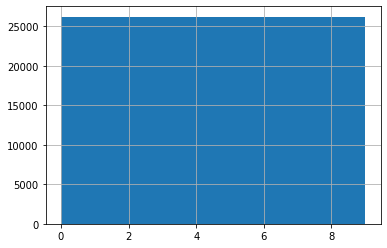

In [16]:
pd.Series(Y_train).hist()
pd.Series(Y_train).describe()

**Question:** Are the statistics for the test set labels sensible?

In [17]:
# Getting the class names
classes = [train[train['class'] == i].iloc[0]['order'] for i in range(10)]
classes

['Bacillales',
 'Streptomycetales',
 'Flavobacteriales',
 'Micrococcales',
 'Rhizobiales',
 'Corynebacteriales',
 'Lactobacillales',
 'Burkholderiales',
 'Clostridiales',
 'Rhodobacterales']

## Task 1: Make a model and fit the data

Expriment to make a model and fit the data.

Spend a little bit of time to this but reserve some time for later tasks. The quality of your model you make now does not matter: you will be provided an already trained model.

In [18]:
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as L

In [ ]:
x = inp = K.Input((None, ))
x = L.Embedding(128, ...)(x)   # 128 = number of ascii code points

## You can try using LSTM:
# x = L.LSTM(...)(x)

## You can try using GRU:
# x = L.GRU(...)(x)

## You can try the bidirectional variant:
# x = L.Bidirectional(...)(x)

## ... or your ideas

# Final classification layer
x = L.Dense(units=..., activation=...)(x)

M = K.Model(inputs=inp, outputs=x)

M.compile(loss='sparse_categorical_crossentropy',
          optimizer='adam',
          metrics=['acc'])

M.summary()

In [ ]:
M.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

### Example solution task 1

Two bidirectional LSTMs using a small dropout with a softmax on top.

In [ ]:
x = i = K.Input((None, ))
x = L.Embedding(128, 128)(x)
x = L.Bidirectional(L.LSTM(512, dropout=0.1, return_sequences=True))(x)
x = L.Bidirectional(L.LSTM(512, dropout=0.1))(x)
x = L.Dense(10, 'softmax')(x)

M = K.Model(inputs=i, outputs=x)

M.compile(loss='sparse_categorical_crossentropy', metrics=['acc'])

M.summary()

## Task 2: Examine model predictions

In this task you can download an already trained model or use your model from the previous task. 

In [19]:
!wget https://github.com/danr/rnn/raw/main/r16S.h5 --no-verbose --no-clobber

In [20]:
# Keras model loading seems broken if you try to import the entire graph.
# You get a model but it is very slow to fit and evaluate.
# Instead we give the graph like this and then load the weights:

def load_pretrained():
    x = i = K.Input((None, ))
    x = L.Embedding(128, 8)(x)
    x = L.Bidirectional(L.LSTM(32, dropout=0.1, return_sequences=True))(x)
    x = L.Bidirectional(L.LSTM(32, dropout=0.1))(x)
    x = L.Dense(10, 'softmax')(x)

    M = K.Model(inputs=i, outputs=x)

    M.compile(loss='sparse_categorical_crossentropy', metrics=['acc'])

    M.summary()
    M.load_weights('r16S.h5')
    return M

MM = load_pretrained()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 8)           1024      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          10496     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 37,002
Trainable params: 37,002
Non-trainable params: 0
_________________________________________________________________


In [21]:
MM.evaluate(X_test[:1000], Y_test[:1000])

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0798 - acc: 0.9730


[0.0798223021812737, 0.973]

One way to look at what the model does is to see what it predicts on small subsequences. We use a sliding window over the sequence of some width.

In [22]:
def slide(seq, width, step=1):
    return [ seq[i:i+width] for i in range(0, len(seq) - width + 1, step) ]

# Example:
slide(b'ABCDEFG', 4)

[b'ABCD', b'BCDE', b'CDEF', b'DEFG']

In [23]:
bytes2array(slide(b'ABCDEFG', 4))

array([[65, 66, 67, 68],
       [66, 67, 68, 69],
       [67, 68, 69, 70],
       [68, 69, 70, 71]], dtype=uint8)

In [24]:
seq = X_test[0].tobytes()
seq, Y_test[0]

(b'GTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCCTAAACGATGTCAACTAGTTGTCGGGTCTTCATTGACTTGGTAACGTAGCTAACGCGTG',
 7)

In [25]:
MM.predict(bytes2array(slide(seq, 20))).argmax(-1)

array([7, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       9, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0, 0, 6, 8, 8, 6, 2, 2,
       6, 6, 6, 6, 2, 6, 1, 3, 3, 3, 3, 6, 3, 6, 6, 6, 0, 0, 6, 6, 6, 6,
       6, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 6, 7])

In [26]:
import seaborn as sns

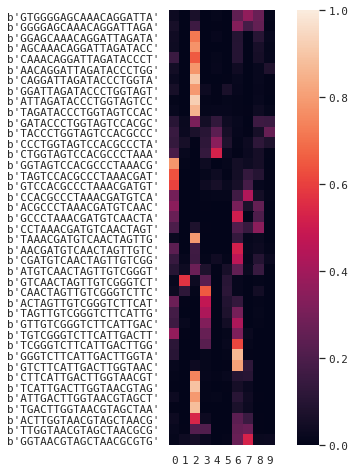

In [27]:
sns.set(rc={'figure.figsize': (8, 8), 
            'font.family': 'monospace'})
sseq = slide(seq, 20, step=2)  # Increase step if the output is too small
sns.heatmap(MM.predict(bytes2array(sseq)), 
            yticklabels=sseq, 
            square=True, vmin=0, vmax=1)

**Activity:** Try increasing the sliding window width and examine the result.

**Activity:** Examine what the network does on other sequence inputs.

**Activity:** Other things to look at: 
* individual neuron activations
* which parts of the entire ref sequences seem to be most predictive
* using the final states to make a phylogeny

In [ ]:
seq = np.frombuffer(b'TGAACGCTGGCGGCATGCCTTACACATGCAAGTCGAACGGCAGCGCGGGAGCAATCCTGGCGGCGAGTGGCGAACGGGTGAGTAATACATCGGAACGTGCCCAATCGTGGGGGATAACGCAGCGAAAGCTGTGCTAATACCGCATACGATCTACGGATGAAAGCAGGGGATCGCAAGACCTTGCGCGAATGGAGCGGCCGATGGCAGATTAGGTAGTTGGTGAGGTAAAGGCTCACCAAGCCTTCGATCTGTAGCTGGTCTGAGAGGACGACCAGCCACACTGGGACTGAGACACGGTCCAGACTCCTACGGGAGGCAGCAGTGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGCAGGATGAAGGCCTTCGGGTTGTAAACTGCTTTTGTACGGAACGAAACGGTCTTTTCTAATACAGAAGGCTAATGACGGTACCGTAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTATGTAAGACAGTTGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGTGACTGCATAGCTAGAGTACGGTAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGACCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCCTAAACGATGTCAACTGGTTGTTGGGTCTTCACTGACTCAGTAACGAAGCTAACGCGTGAAGTTGACCGCCTGGGGAGTACGGCCGCAAGGTTGAAACTCAAAGGAATTGACGGGGACCCGCACAAGCGGTGGATGATGTGGTTTAATTCGATGCAACGCGAAAAACCTTACCCACCTTTGACATGTACGGAATTCGCCAGAGATGGCTTAGTGCTCGAAAGAGAACCGTAACACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCTTGTCATTAGTTGCTACATTCAGTTGGGCACTCTAATGAGACTGCCGGTGACAAACCGGAGGAAGGTGGGGATGACGTCAAGTCCTCATGGCCCTTATAGGTGGGGCTACACACGTCATACAATGGCTGGTACAAAGGGTTGCCAACCCGCGAGGGGGAGCTAATCCCATAAAACCAGTCGTAGTCCGGATCGCAGTCTGCAACTCGACTGCGTGAAGTCGGAATCGCTAGTAATCGTGGATCAGAATGTCACGGTGAATACGTTCCCGGGTCTTGTACACACCGCCCGTCACACCATGGGAGCGGGTTCTGCCAGAAGTAGTTAGCTTAACCGCAAGGAGGGCGATTACCACGGCAGGGTTCGTGACTGGGGTGAAGTCGTAACAAGGTAGCCA', np.uint8)
seq = np.frombuffer(b'ATTGAACGCTGGCGGCATGCTTTACACATGCAAGTCGAACGGCAGCACAGGGAGCTTGCTCCCGGGTGGCGAGTGGCGCACGGGTGAGTAAGACATCGGAACGTGTCCTCTTGTGGGGGATAACTACCCGAAAGGGTGGCTAATACCGCATAAGTCCTGAGGGAGAAAGCGGGGGATCTTCGGACCTCGCGCGAGAGGAGCGGCCGATGGCCGATTAGCTAGTTGGTGAGGTAAAGGCTCACCAAGGCGACGATCGGTAGCTGGTCTGAGAGGACGACCAGCCACACTGGGACTGAGACACGGCCCAGACTCCTACGGGAGGCAGCAGTGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGTGGGATGAAGGCCTTCGGGTTGTAAACCACTTTTGTCAGGGACGAAAAGGTTCAGGCYAATACCTTGAACTGCTGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTCTGTAAGATAGATGTGAAATCCCCGGGCTTAACCTTGGAATTGCATTTATGACTGCAGGACTCGAGTTTGTCAGAGGGGGGTGGAATTCCAAGTGTAGCAGTGAAATGCGTAGATATTTGGAAGAACACCGATGGCGAAGGCAGCCCCCTGGGACATGACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCCTAAACGATGTCTACTGGTTGTTGGGGACGATTTGGTCCTTGGTAACGAAGCTAACGCGTGAAGTAGACCGCCTGGGGAGTACGGTCGCAAGATTAAAACTCAAAGGAATTGACGGGGACCCGCACAAGCGGTGGATGATGTGGATTAATTCGATGCAACGCGAAAAACCTTACCTAGCCTTGACATGTCGGAAAGCTCTGAGAGATCGGAGYGTGCCCGCAAGGGAATCCGAACACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCTTGTCACTAGTTGCTACGAAAGGGCACTCTAGTGAGACTGCCGGTGACAAACCGGAGGAAGGTGGGGATGACGTCAAGTCCTCATGGCCCTTATGGCTAGGGCCTCACACGTCATACAATGGTCGGAACAGAGGGCAGCGAAGCCGCGAGGTGGAGCAAATCCCAGAAAACCGATCGTAGTCCGGATTGCAGTCTGCAACTCGACTGCATGAAGTCGGAATCGCTAGTAATCGCGGATCAGCATGCCGCGGTGAATACGTTCCCGGGTCTTGTACACACCGCCCGTCACACCATGGGAGTGGGGTTCACCAGAAGACGTTTGTCTAACCGCAAGGAGGACGGCGTCCACGGTGGGTTTCATGACTGGGGTGAAGTCGTAACAAGGTAGCCGTACCGGAAGG', np.uint8)
#seq = np.frombuffer(b'GGTACGACAGAGAAACTTGTTTCTTGGTGGCGAGCGGCGGACGGGTGAGTAATGCTTGGGAACATGCCTTTAGGTGGGGGACAACAGTTGGAAACGACTGCTAATACCGCATGATGTCTACGGACCAAAGTGGGGGACCTTCGGGCCTCACGCCTAAAGATTGCCCAAGGTGGGATTAGCTAGTTGGTGAGGTAATGGCTCACCAAGGCAACGATCTCTAGCTGGTTTGAGAGGATGATCAGCCACACTGGAACTGAGACACGGTCCAGACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGAAAGCTGATGCAGCCATGCCGCGTGTGTGAAGAAGGCCTTCGGGTTGTAAAGTACTTTCAGTCAGGAGGAAGGTTACGTTTTTAATAGAAGCGTAGCTGTGACGTTATCGACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTTGATTAAGCGAGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTTCGAACTGGTCAACTAGAGTGTGATAGAGGGTGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGATGGCGAAGGCAGCCACCTGGGTCAACACTGACGCTCATGTACGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGTCTACTAGAAGCTGGGGTCCTCGACAACTTTTTCAAAGCTAACGCATTAAGTAGACCGCCTGGGGAGTACGTCGCAAGTTAAAACTCAAATGAATTGACGGGGGCCCGCACAAGCGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAAGAAGGCCTACCTTGACATCCAGAGAAATCGCTAGAGATAGCTTTGTGCCTTCGGGAACTCTGAGACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTTGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCCTATCCTTAGTTGCCAGCGAGTAATGTCGGGAACTCTAAGGAGACTGCCGGTGATAAACCGGAGGAAGGTGGGGACGACGTCAAGTCATCATGGCCCTTACGTGTAGGGCTACACACGTGCTACAATGGCGAGTACAGAGGGCAGCAAGCTAGCGATAGTGAGCGAATCCTTAAAAGCTCGTCGTAGTCCGGATTGGAGTCTGCAACTCGACTCCATGAAGTCGGAATCGCTAGTAATCCTAAATCAGAATGTTGTGCGAATACGTTCCCGGGCCTTGTACACACCGCCCG', np.uint8)
#seq = np.frombuffer(b'TATCACTTTTGAACTTGATGAAAGGATTGATAAAGTACTTAATGAGAAGTGCTCTGCCTATACAGTTGAACTCGGTACAGAAGTAAATGAGTTCGCCTGTGTTGTGGCAGATGCTGTCATAAAAACTTTGCAACCAGTATCTGAATTAC', np.uint8)

## Task 3: transfer learning to a new classification task

We will turn to studying 16S sequences on only two types of Bacillales.

Might remove this because it's more concepts to introduce this late in the exercise to basically just wait for fit and then examine it in the same way as Task 2.

In [28]:
%%bash
wget https://github.com/danr/rnn/raw/main/Bacillales-{test,train}.csv.gz --no-verbose --no-clobber

In [29]:
B_train = pd.read_csv('./Bacillales-train.csv.gz')
B_test = pd.read_csv('./Bacillales-test.csv.gz')

In [30]:
B_train.head()

,class,seq,family
0,1,AAGGCTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGT...,Paenibacillaceae
1,1,GGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACG...,Paenibacillaceae
2,1,AGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAG...,Paenibacillaceae
3,0,GATGGGCCCGCGGCGCATTAGTTAGTTGGTGAGGTAAAGGCTCACC...,Bacillaceae
4,0,CGATGAGTGCTAGGTGTTAGGGGGTTTCCGCCCCTTAGTGCTGAAG...,Bacillaceae


In [31]:
XB_train = bytes2array(B_train.seq.astype('bytes').values)
XB_test  = bytes2array(B_test.seq.astype('bytes').values)
XB_train.shape, XB_test.shape

((262144, 100), (262144, 100))

**Question:** Are the array shapes the expected shapes?

You can view the bytes of a single sequence with `.tobytes`:

In [32]:
XB_train[0].tobytes()

b'AAGGCTTGAGTGCAGAAGAGGAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGGCTG'

**Question:** Is this an actual sequence from the training data csv file?

Create the label arrays.

In [33]:
YB_train = B_train['class'].values
YB_test  = B_test['class'].values
YB_train.shape, YB_test.shape

((262144,), (262144,))

**Question:** Are the shapes correct?

A simple way to get some stats for the labels is to convert them to a `pd.Series` and `.describe()` it. Another way is to plot `.hist()`.

count    262144.000000
mean          0.500000
std           0.500001
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
dtype: float64

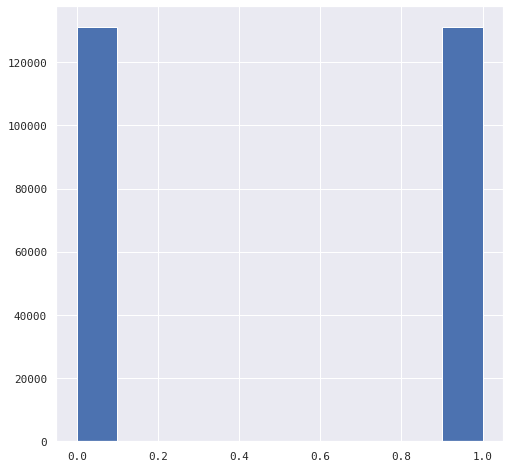

In [34]:
pd.Series(YB_train).hist()
pd.Series(YB_train).describe()

In [79]:
MB = load_pretrained()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 8)           1024      
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 64)          10496     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 37,002
Trainable params: 37,002
Non-trainable params: 0
_________________________________________________________________


In [77]:
MB.evaluate(XB_test[:1000], YB_test[:1000])

1000/1000 [==============================] - 1s 1ms/sample - loss: 8.3111 - acc: 0.4950


[8.311069358825684, 0.495]

In [80]:
MB.layers[-1].bias[2:].assign([-100] * 8)

<tf.Variable 'UnreadVariable' shape=(10,) dtype=float32, numpy=
array([  -0.7263175,   -1.3044032, -100.       , -100.       ,
       -100.       , -100.       , -100.       , -100.       ,
       -100.       , -100.       ], dtype=float32)>

In [81]:
MB.fit(XB_train[:50000], YB_train[:50000], epochs=1, validation_data=(XB_test[:1000], YB_test[:1000]))

Train on 50000 samples, validate on 1000 samples
50000/50000 [==============================] - 60s 1ms/sample - loss: 0.2645 - acc: 0.8986 - val_loss: 0.1169 - val_acc: 0.9580


b'GTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCCTAAACGATGTCAACTAGTTGTCGGGTCTTCATTGACTTGGTAACGTAGCTAACGCGTG' 7


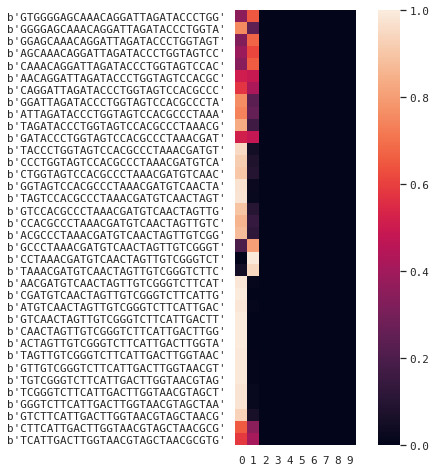

In [82]:
seq = X_test[0].tobytes()
print(seq, Y_test[0])
sns.set(rc={'figure.figsize': (8, 8), 
            'font.family': 'monospace'})
sseq = slide(seq, 30, step=2)  # Increase step if the output is too small
sns.heatmap(MB.predict(bytes2array(sseq)), 
            yticklabels=sseq, 
            square=True, vmin=0, vmax=1)

b'GTTGCCAGGGAAGAAGGCTAGGGAGAGTGGAAAGCTCTTTAGTTGACGGTACCTGAGAAGAAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATAC' 1


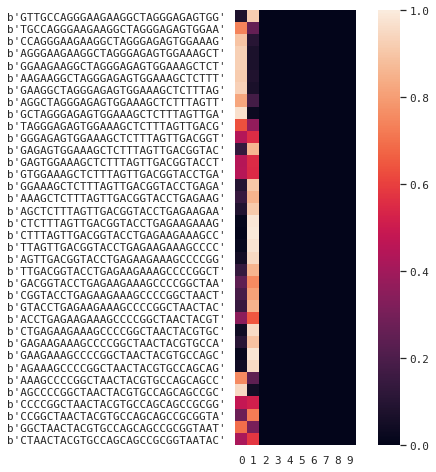

In [83]:
seq = XB_test[0].tobytes()
print(seq, YB_test[0])
sns.set(rc={'figure.figsize': (8, 8), 
            'font.family': 'monospace'})
sseq = slide(seq, 30, step=2)  # Increase step if the output is too small
sns.heatmap(MB.predict(bytes2array(sseq)), 
            yticklabels=sseq, 
            square=True, vmin=0, vmax=1)

## Appendix: drawing confusion matrices

This is some code I had lying around while experimenting. Might not be useful.

In [ ]:
cm = pd.crosstab(Y_test, P.argmax(axis=1), rownames=['target'], colnames=['pred'])

In [ ]:
cm = cm.rename(index=dict(enumerate(classes)), columns=dict(enumerate(classes)))

In [ ]:
sns.heatmap(cm, square=True, cmap='Blues')